### Active Learning with Gaussian Process

In my previous post, I had introduced Gaussian Process. In this post, I am going to focus on the task of active learning - where we query the user/oracle to label samples. The main motivation behind active learning is the expensive cost of labelling in machine learning tasks. 

#### Mining Gold!

In this post, we will assume a mining application - mining for gold! We will simplify the problem by stating that we need to search for gold in a 1d search space. At each prospective location, we have to drill a hole and use some expensive sensors to find out the amount of gold in that location. Given the expensive nature of this drilling, we would not be able to drill at all locations. Thus, the active learning problem comes into picture.

#### Problem: Determine which location to next drill


We would be starting with some very naive assumption that the gold distribution of nearby points in similar (smoothness). GPs fit very well in this active learning problem as they give us not only the predictions but also the uncertainty. One popular active learning strategy is to choose the next location to drill (or query in more general sense) as the location about which we are most uncertain about (highest variance).

Here is a representative animation showing the process of drilling at new locations and reducing the undertainty. We will build this from ground up in this post.

![](active-gp.gif)

#### Some imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.gaussian_process import GaussianProcessRegressor
%matplotlib inline

#### Prettyfing Matplotlib plots

In [2]:
SPINE_COLOR = 'gray'

def format_axes(ax):
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)

    for spine in ['left', 'bottom']:
        ax.spines[spine].set_color(SPINE_COLOR)
        ax.spines[spine].set_linewidth(0.5)

    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    for axis in [ax.xaxis, ax.yaxis]:
        axis.set_tick_params(direction='out', color=SPINE_COLOR)

    return ax

#### Creating ground truth data

In [3]:
def f(x):
    """The function to predict."""
    return 2*((x-3)*np.sin((x-3))) + 2 + 0.5*x

Let us now try to see how our groundtruth data looks like.

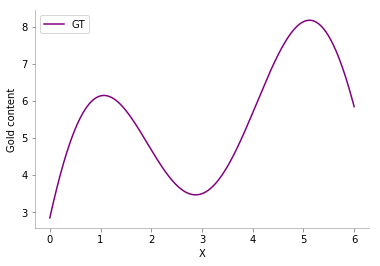

In [4]:
x = np.atleast_2d(np.linspace(0, 6, 1000)).T
plt.plot(x, f(x), color='purple', label='GT')
plt.xlabel("X")
plt.ylabel("Gold content")
plt.legend()
format_axes(plt.gca())

#### Plotting our prior model

Our prior model doesn't know much and assumes a smooth relationship between points via an RBF kernel.

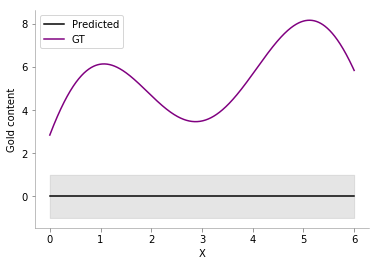

In [5]:
gp = GaussianProcessRegressor()
y_pred, sigma = gp.predict(x, return_std=True)
plt.plot(x, y_pred, 'k', label='Predicted', lw=1.5)
plt.plot(x, f(x), 'purple', label='GT', lw=1.5)
plt.xlabel("X")
plt.ylabel("Gold content")
plt.fill_between(x.flatten(), y_pred+sigma, y_pred-sigma, color='gray', alpha=0.2)
plt.legend()
format_axes(plt.gca())

Looks like our prediction isn't very useful at this point. But, we haven't seen any data yet, right! We can also see the same variance at all the data points. 

### Adding a point to the train set

Let us now add a point to the train set and see how our posterior changes after we fit the model to the new data. I am going to add `(x = 0.5, y = f(0.5))` into the train set now.

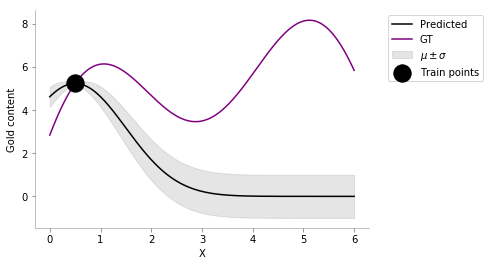

In [6]:
train_X = np.atleast_2d([0.5]).T
train_y = f(train_X).ravel()
gp.fit(train_X, train_y)
y_pred, sigma = gp.predict(x, return_std=True)
plt.plot(x, y_pred, 'k', label='Predicted')
plt.plot(x, f(x), 'purple', label='GT')
plt.xlabel("X")
plt.ylabel("Gold content")
plt.fill_between(x.flatten(), y_pred+sigma, y_pred-sigma, color='gray', alpha=0.2, label=r'$\mu \pm \sigma$')
plt.scatter(train_X, train_y, color='black', s=300, zorder=10, label='Train points')
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
format_axes(plt.gca())

Nice, we can see now that the posterior has changed. We are very certain about the points in the vicinity of x = 0.5, but, very uncertain far away from it. So, we now come to the key idea.

#### Active learning procedure

1. Choose the point having highest uncertainty
2. Add the point to train set
3. Train on the new train set
4. Go to 1 till convergence or budget elapsed

In [7]:
# Stopping criteria is 10 iterations
for i in range(10):
    # Fit on current train set
    gp.fit(train_X, train_y.flatten())
    # predict on current pool set
    y_pred, sigma = gp.predict(x, return_std=True)
    plt.plot(x, y_pred, 'k', label='Predicted')
    plt.plot(x, f(x), 'purple', label='GT')
    plt.xlabel("X")
    plt.ylabel("Gold content")
    plt.fill_between(x.flatten(), y_pred+sigma, y_pred-sigma, color='gray', alpha=0.2, label=r'$\mu \pm \sigma$')
    plt.scatter(train_X, train_y, color='black', s=300, zorder=10, label='Train points')
    plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
    plt.title(f"Iteration: {i}")
    format_axes(plt.gca())
    plt.ylim((1, 9))
    plt.xlim((-1, 7))
    plt.savefig(f"active-gp-img/{i}.png", bbox_inches="tight")
    plt.close()
    
    # Choose the next point with highest sigma
    next_ix = np.argmax(sigma)
    next_x = x[next_ix]
    # Add new point with highest uncertainty to the pool set
    train_X = np.vstack([train_X, [x[next_ix]]])
    train_y = f(train_X)

Let us now write a simple function to create the animation shown at the top of the post!

In [8]:
!convert -delay 40 -loop 0 active-gp-img/*.png active-gp.gif